# Following the Xenium Data Analysis tutorial from: 
## https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_xenium.html#

### Creating a micromamba environment to install the necessary packages for the tutorial.

In [1]:
# !micromamba create -y -n xenium_analysis
# !micromamba activate xenium_analysis
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install scanpy
# !pip install squidpy

### Import the necessary packages.

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import squidpy as sq

### Create proper folder structure and load in the data.

In [ ]:
# !mkdir tutorial_data
# !mkdir tutorial_data/xenium_data
# !curl -o tutorial_data/xenium_data/ https://cf.10xgenomics.com/samples/xenium/preview/Xenium_FFPE_Human_Breast_Cancer_Rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_cell_feature_matrix.h5
# !curl -o tutorial_data/xenium_data/Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv.gz https://cf.10xgenomics.com/samples/xenium/preview/Xenium_FFPE_Human_Breast_Cancer_Rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv.gz

In [3]:
adata = sc.read_10x_h5(
    filename="tutorial_data/xenium_data/Xenium_FFPE_Human_Breast_Cancer_Rep1_cell_feature_matrix.h5"
)

In [4]:
df = pd.read_csv(
    "tutorial_data/xenium_data/Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv"
)

In [5]:
df.set_index(adata.obs_names, inplace=True)
adata.obs = df.copy()

In [6]:
adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

### Preview the data.

In [7]:
adata.obs

,cell_id,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,total_counts,cell_area,nucleus_area
1,1,377.663005,843.541888,154,0,0,154,110.361875,45.562656
2,2,382.078658,858.944818,64,0,0,64,87.919219,24.248906
3,3,319.839529,869.196542,57,0,0,57,52.561875,23.526406
4,4,259.304707,851.797949,120,0,0,120,75.230312,35.176719
5,5,370.576291,865.193024,120,0,0,120,180.218594,34.499375
...,...,...,...,...,...,...,...,...,...
167778,167778,7455.404785,5115.021094,238,1,0,239,219.956094,61.412500
167779,167779,7483.771045,5111.720703,80,0,0,80,38.427969,25.964844
167780,167780,7470.119580,5119.350366,406,0,0,406,287.690469,86.158125
167781,167781,7477.704004,5128.963086,120,0,0,120,235.670469,25.016563


## Calculate quality control metrics

### QC anndata.AnnData with scanpy.pp.calculate_qc_metrics

In [8]:
sc.pp.calculate_qc_metrics(adata, percent_top=(10, 20, 50, 150), inplace=True)

### Calculate % of control probes and codewords from adata.obs

In [9]:
cprobes = (
    adata.obs["control_probe_counts"].sum() / adata.obs["total_counts"].sum() * 100
)
cwords = (
    adata.obs["control_codeword_counts"].sum() / adata.obs["total_counts"].sum() * 100
)
print(f"Negative DNA probe count % : {cprobes}")
print(f"Negative decoding count % : {cwords}")

Negative DNA probe count % : 0.08700852649698224
Negative decoding count % : 0.005482476054877954


### Plot the distribution of total transcripts per cell, area of segmented cells, and the ratio of nuclei area to their cells

<Axes: title={'center': 'Nucleus ratio'}, ylabel='Count'>

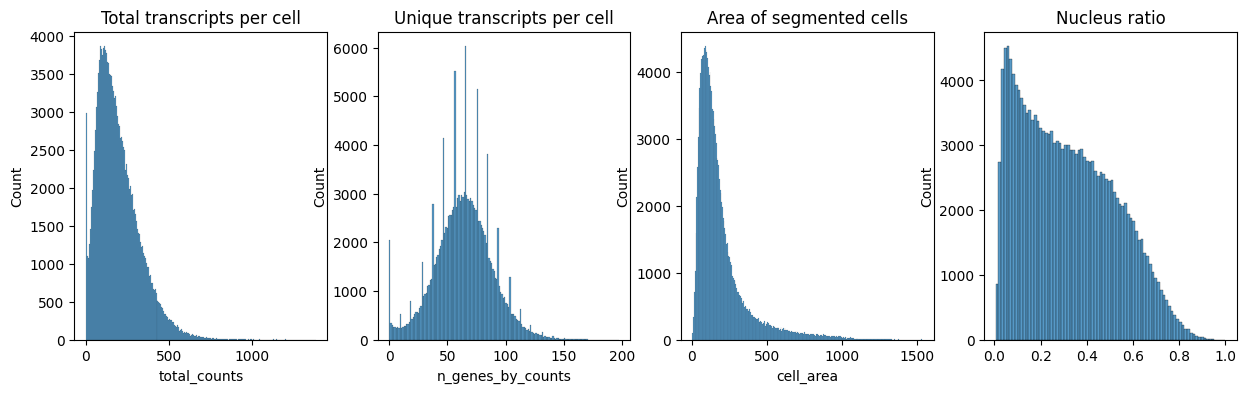

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    adata.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)


axs[2].set_title("Area of segmented cells")
sns.histplot(
    adata.obs["cell_area"],
    kde=False,
    ax=axs[2],
)

axs[3].set_title("Nucleus ratio")
sns.histplot(
    adata.obs["nucleus_area"] / adata.obs["cell_area"],
    kde=False,
    ax=axs[3],
)

### Filter out the cells based on minimum number of counts and filter out genes based on minimum number of cells

In [11]:
sc.pp.filter_cells(adata, min_counts=10)
sc.pp.filter_genes(adata, min_cells=5)

#### Other filter criteria could be cell area, DAPI signal, or minimum number of unique transcripts

### Normalize the cell counts with sc.pp.normalize_total

### Logarithmize, do PCA, compute a neighborhood graph of observations

### Use sc.tl.umap to embed the neighborhood graph of the data and cluster the cells into subgroups with sc.tl.leiden(adata)

In [12]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

c:\Users\andrew\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\andrew\AppData\Local\Temp\ipykernel_19940\4193936636.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


## Visualize annotation on UMAP and spatial coordinates

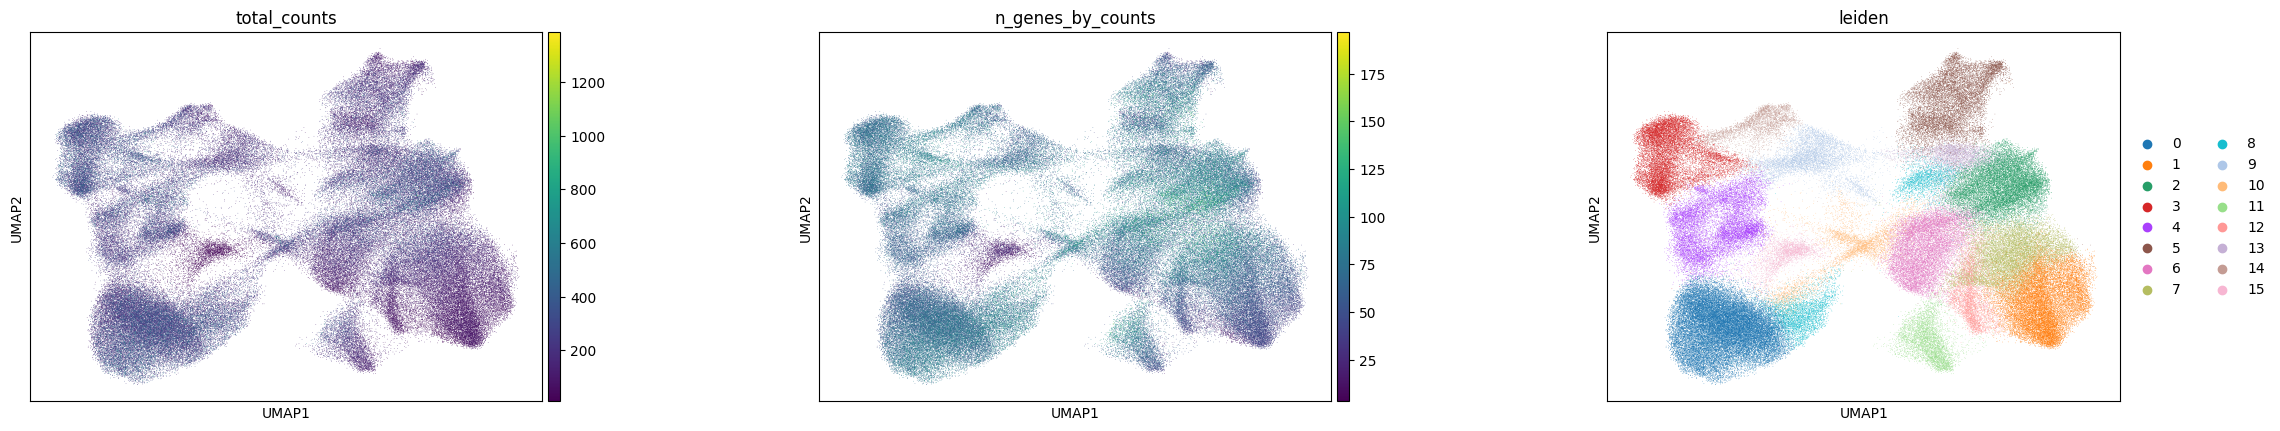

In [13]:
sc.pl.umap(
    adata,
    color=[
        "total_counts",
        "n_genes_by_counts",
        "leiden",
    ],
    wspace=0.4,
)

c:\Users\andrew\AppData\Local\Programs\Python\Python312\Lib\site-packages\squidpy\pl\_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


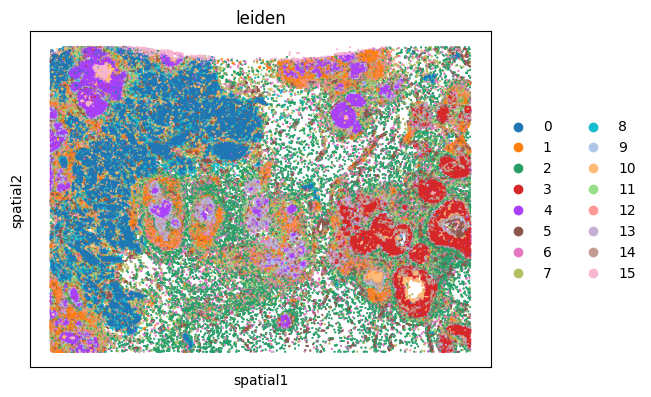

In [14]:
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    color=[
        "leiden",
    ],
    wspace=0.4,
)

## Compute spatial statistics

### Building the spatial neighbors graph

In [15]:
sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)

## Compute centrality scores

In [16]:
sq.gr.centrality_scores(adata, cluster_key="leiden")

### Visualize the results

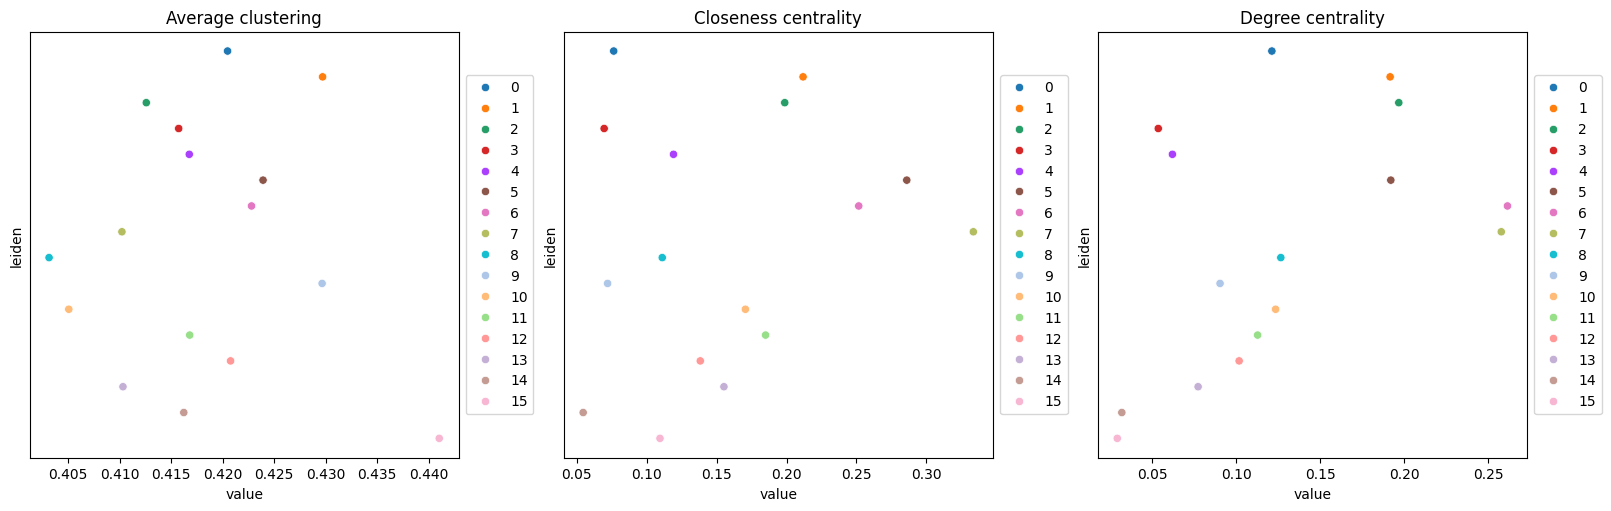

In [17]:
sq.pl.centrality_scores(adata, cluster_key="leiden", figsize=(16, 5))

## Compute co-occurence probability

In [18]:
adata_subsample = sc.pp.subsample(adata, fraction=0.5, copy=True)

100%|██████████| 861/861 [13:57<00:00,  1.03/s]


c:\Users\andrew\AppData\Local\Programs\Python\Python312\Lib\site-packages\squidpy\pl\_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


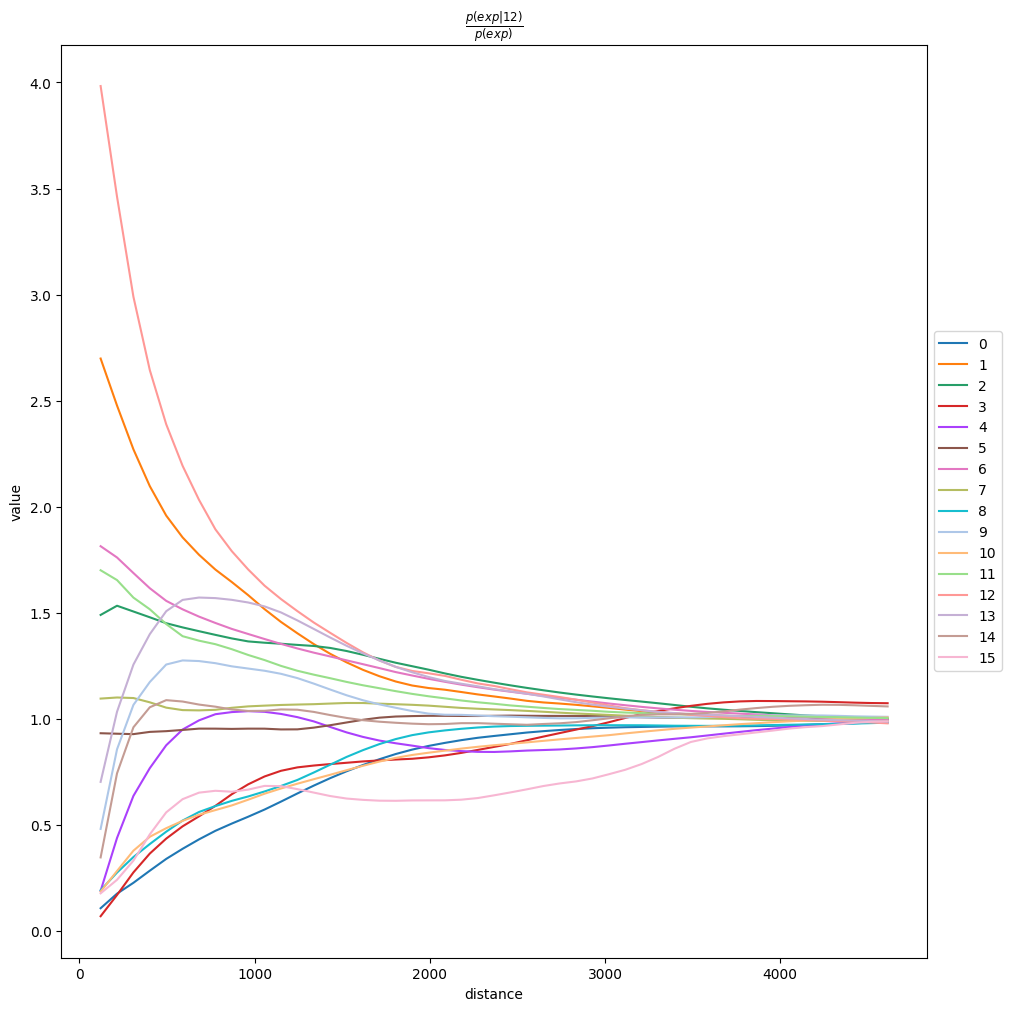

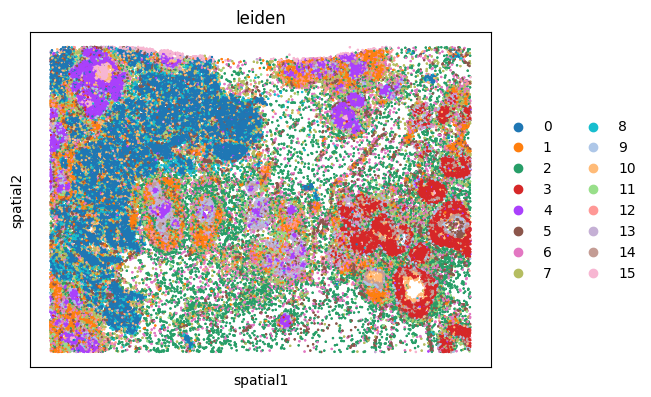

In [19]:
sq.gr.co_occurrence(
    adata_subsample,
    cluster_key="leiden",
)
sq.pl.co_occurrence(
    adata_subsample,
    cluster_key="leiden",
    clusters="12",
    figsize=(10, 10),
)
sq.pl.spatial_scatter(
    adata_subsample,
    color="leiden",
    shape=None,
    size=2,
)

## Neighbors enrichment analysis

In [20]:
sq.gr.nhood_enrichment(adata, cluster_key="leiden")

100%|██████████| 1000/1000 [00:14<00:00, 68.02/s]


### Visualize the results

c:\Users\andrew\AppData\Local\Programs\Python\Python312\Lib\site-packages\squidpy\pl\_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


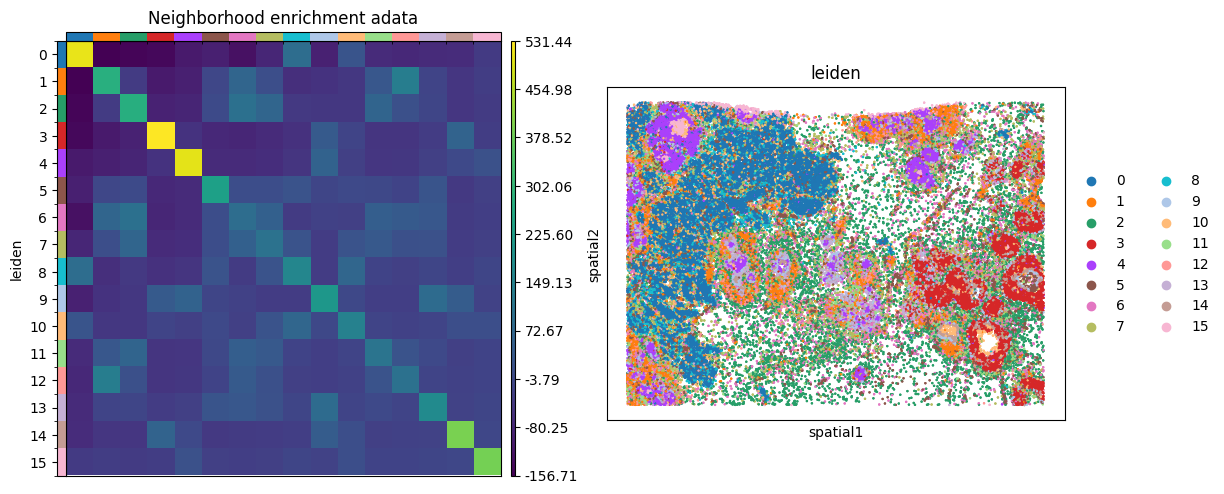

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(13, 7))
sq.pl.nhood_enrichment(
    adata,
    cluster_key="leiden",
    figsize=(8, 8),
    title="Neighborhood enrichment adata",
    ax=ax[0],
)
sq.pl.spatial_scatter(adata_subsample, color="leiden", shape=None, size=2, ax=ax[1])

## Compute Moran's I score

In [22]:
sq.gr.spatial_neighbors(adata_subsample, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(
    adata_subsample,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)
adata_subsample.uns["moranI"].head(10)

100%|██████████| 100/100 [00:56<00:00,  1.77/s]


,I,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh
KRT7,0.696668,0.0,0.000004,0.0,0.009901,0.000010,0.0,0.0,0.009997
SCD,0.671975,0.0,0.000004,0.0,0.009901,0.000008,0.0,0.0,0.009997
FOXA1,0.659014,0.0,0.000004,0.0,0.009901,0.000010,0.0,0.0,0.009997
FASN,0.653400,0.0,0.000004,0.0,0.009901,0.000009,0.0,0.0,0.009997
EPCAM,0.641954,0.0,0.000004,0.0,0.009901,0.000008,0.0,0.0,0.009997
TACSTD2,0.638978,0.0,0.000004,0.0,0.009901,0.000008,0.0,0.0,0.009997
CEACAM6,0.631554,0.0,0.000004,0.0,0.009901,0.000009,0.0,0.0,0.009997
ERBB2,0.628083,0.0,0.000004,0.0,0.009901,0.000010,0.0,0.0,0.009997
KRT8,0.619555,0.0,0.000004,0.0,0.009901,0.000009,0.0,0.0,0.009997
LUM,0.593700,0.0,0.000004,0.0,0.009901,0.000007,0.0,0.0,0.009997


### Visualize the results

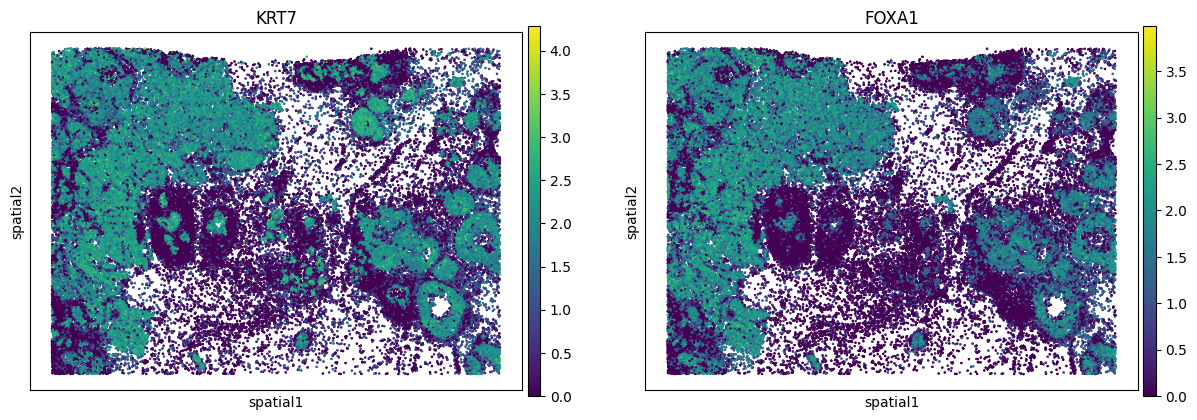

In [23]:
sq.pl.spatial_scatter(
    adata_subsample,
    library_id="spatial",
    color=[
        "KRT7",
        "FOXA1",
    ],
    shape=None,
    size=2,
    img=False,
)